# Cause of overestimated sparse units

author: steeve.laquitaine@epfl.ch

TODO:
- check source code to detect overmerging

Setup environment: 

```bash
pip install requirements_kilosort_silico
```

In [16]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import bisect
import spikeinterface as si

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.postpro.feateng import (add_firing_rates)
from src.nodes.postpro.cell_matching import get_missed_units, get_detected_units


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
MATCH_WIND_MS = 0.4
SAMPLING_FREQ = 10000 # sample/sec

# GET RUN CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]

LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"

# set Kilosort sorted spikes and cells path
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# set ground truth spikes and cells path
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-06-02 19:09:18,702 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-02 19:09:18,728 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [17]:
# get the sorted units associated with the sparse true units
match = match_sorted_to_true_neuropixels_2023_02_19(GT_SORTING_PATH, KS3_SORTING_PATH)

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit"][
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["missed"][cell_matching["true_unit"].isin(missed)] = True


In [18]:
# are the sorted units overmerged (have non zero agreement scores with other true units)
# get matching object
MatchingObject = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH)

In [19]:
# get matching data
matching = match["cell_matching"]
matching = add_firing_rates(matching, GT_SORTING_PATH, KS3_SORTING_PATH, data_conf)
matching = matching.dropna(subset=['true_unit'])

In [20]:
# find detected sparse true units
detected_units = get_detected_units(MatchingObject.agreement_scores)
sparse_true_units = matching["true_unit"][matching["true firing rate"] < LOW_RATE_CEILING].astype(int)
detected_sparse_true_loc = (matching["true_unit"].isin(detected_units)) & (matching["true_unit"].isin(sparse_true_units))

In [21]:
# get sorted units for these detected sparse units
matching = matching[detected_sparse_true_loc]
sorted_units = matching["sorted_unit"].unique()

In [22]:
# get sorted units scores with true units
sorted_units_score = MatchingObject.agreement_scores.loc[:, sorted_units]
notnull_scores = sorted_units_score > 0
not_null_count = notnull_scores.sum(axis=0)

# count overmerged or not
n_total = len(sorted_units)
n_overmerged = sum(not_null_count > 1)
n_not_overmerged = n_total - n_overmerged

percent_overmerged = n_overmerged/n_total*100
percent_not_overmerged = n_not_overmerged/n_total*100

## Overmerging hypothesis: Spurious spikes from other units explain the overestimation of sparse unit firing rates


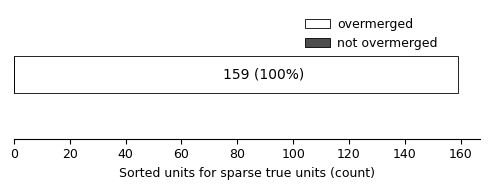

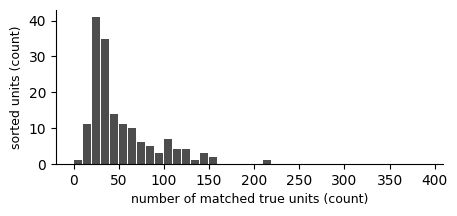

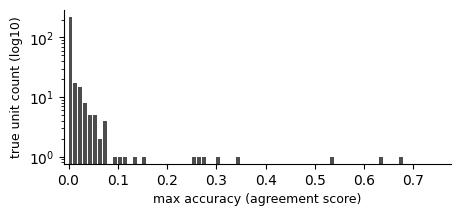

In [23]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_overmerged,
            n_not_overmerged,
        ],
    },
    index=["overmerged", "not overmerged"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["k", "w"]
percents = [percent_overmerged, percent_not_overmerged]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("Sorted units for sparse true units (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)

# ax.set_title("Overmerging explains sparse unit overestimated FR", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
x_shift = 10
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    if not width==0:
        ax.text(
            x + width / 2 + x_shift,
            y + height / 2,
            "{:.0f} ({:.0f}%)".format(width, percents[p_i]),
            horizontalalignment="center",
            verticalalignment="center",
            color=txt_colors[p_i],
        )
    
# set firing rate bins
fig, ax = plt.subplots(figsize=(5,2))
bin_width = 9

BINS = np.arange(0, 400, 10)

ax = not_null_count.hist(bins=BINS, width=bin_width, color=[0.3, 0.3, 0.3]);

# legend
ax.set_xlabel("number of matched true units (count)", fontsize=9)
ax.set_ylabel("sorted units (count)", fontsize=9)
ax.grid(False)
ax.spines[["right", "top"]].set_visible(False)

# plot agreement scores
detected_sparse_true_units = matching["true_unit"].astype(int).tolist()
scores_detected_sparse_true_units = MatchingObject.agreement_scores.loc[detected_sparse_true_units,:]
true_unit_accuracy = scores_detected_sparse_true_units.max(axis=1)

# set firing rate bins
fig, ax = plt.subplots(figsize=(5,2))

# set plot params
bin_width = 0.008
BINS = np.arange(0, 1, 0.01)

# plot
ax = true_unit_accuracy.hist(bins=BINS, width=bin_width, color=[0.3, 0.3, 0.3]);

# legend
ax.set_xlabel("max accuracy (agreement score)", fontsize=9)
ax.set_ylabel("true unit count (log10)", fontsize=9)
ax.grid(False)
ax.spines[["right", "top"]].set_visible(False)
ax.set_yscale('log')
ax.set_xlim([-0.01, true_unit_accuracy.max()+0.1]);

In [24]:
print("detected sparse true units (total count):", matching.shape[0])

detected sparse true units (total count): 292


## Noise hypothesis: All sorted units also contained noise - 90% contained more than 50% of noise.


In [25]:
def count_noise_ttp(sorted_ttps, true_ttps, match_wind:int=4):
    """count noise signals in a sorted units' spike train
    A noise signal is a signal that matches no timestamp
    from any true units (within match_wind)

    Args:
        sorted_ttps (_type_): _description_
        true_ttps (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Create a NumPy array from array2
    array2 = np.array(true_ttps)
    array1 = np.array(sorted_ttps)

    # Check if any value in array1 is within a distance of match_wind from array2
    mask = np.any(np.abs(array1[:, np.newaxis] - array2) <= match_wind, axis=1)

    # Count the number of values in array1 that are not within the desired distance
    count = np.sum(~mask)
    return count

In [26]:
# convert (0.4 ms in SpikeInterface) matching window to timepoints
match_wind = int(MATCH_WIND_MS * SAMPLING_FREQ / 1000)

# get the near-contact true units ids
true_units_ids = match["cell_matching"]["true_unit"].tolist()

# get the timestamps of sorted units matched to detected sparse true units 
Sorting = si.load_extractor(KS3_SORTING_PATH)

# get the true units spike timestamps
Truth = si.load_extractor(GT_SORTING_PATH)

# get all true unit timestamps
true_ttps = []
for unit_i in true_units_ids:
    true_ttps += Truth.get_unit_spike_train(unit_i).tolist()

# count the noise timestamps for a sorted unit (LOOPING OVER ALL UNITS TOO SLOW)
noise_ratios = []
noise_counts = []
for sorted_i in sorted_units:
    sorted_ttps = Sorting.get_unit_spike_train(unit_id=sorted_i)
    noise_count = count_noise_ttp(sorted_ttps, true_ttps, match_wind)
    noise_counts.append(noise_count)
    noise_ratios.append(noise_count/len(sorted_ttps))

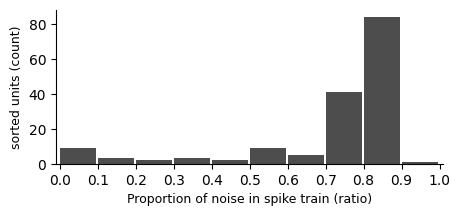

In [27]:
# plot
bins = np.arange(0,1.1,0.1)
fig, ax = plt.subplots(figsize=(5,2))
ax.hist(noise_ratios, bins=bins, width=0.095, color=(0.3, 0.3, 0.3));
ax.set_xticks(bins)
ax.set_xlim([-0.01, 1.01]);
ax.set_xlabel("Proportion of noise in spike train (ratio)", fontsize=9)
ax.set_ylabel("sorted units (count)", fontsize=9)
ax.grid(False)
ax.spines[["right", "top"]].set_visible(False)

In [226]:
print("Sorted units with more than 50% noise (ratio):", sum(np.array(noise_ratios) > 0.5)/len(noise_ratios))

Sorted units with more than 50% noise (ratio): 0.8805031446540881
